# Business Context

## Company Background:
You work as a Data Analyst at a mid-sized e-commerce company that sells home and lifestyle products online.


The marketing team recently redesigned the product detail page (PDP) to improve user engagement and purchase conversion.

## 🎯 Experiment Goal:

The goal of the A/B test was to determine whether the new product page design (Group B) leads to higher conversion rates than the current design (Group A).

## 🧩 Experiment Setup

Group A: Control — existing product page (traditional layout, minimal product information).

Group B: Treatment — new layout with larger product images, customer reviews near the top, and AI-powered product recommendations.

Randomization Unit: Individual users (based on User ID).

Duration: Two weeks.

Metrics:

- Primary metric: Conversion — whether a user made a purchase during their session (Yes/No).

Secondary metrics:

- Page Views: number of pages viewed during the session (proxy for engagement)

- Time Spent: time spent on site (in seconds)

Segments (for deeper analysis):

- Device: Mobile vs Desktop

- Location: geographic segmentation across the UK (England, Scotland, Wales, Northern Ireland)

## 1. Data cleaning and processing

In [1]:
import pandas as pd

df = pd.read_csv('ab_testing.csv')
print(df.info() )
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB
None


,user_id,group,page_views,time_spent,conversion,device,location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


## 1.1 check duplicate rows and convert "conversion" col

In [2]:
df.duplicated(subset='user_id').sum()


0

In [3]:
df['conversion'] = df['conversion'].map({'Yes': 1, 'No': 0})
df.head()

,user_id,group,page_views,time_spent,conversion,device,location
0,14292,B,3,424,0,Mobile,Northern Ireland
1,11682,A,9,342,0,Mobile,Scotland
2,19825,A,2,396,0,Desktop,Northern Ireland
3,16080,B,4,318,0,Desktop,Wales
4,18851,A,1,338,1,Desktop,Scotland


## 1.2 Check SRM

In [4]:
df['group'].value_counts(normalize=True)

group
A    0.5038
B    0.4962
Name: proportion, dtype: float64

## 1.3 Check metrics 

In [5]:
df_metrics = df.groupby(['group'])[['page_views', 'time_spent', 'conversion']].mean().reset_index()
print( df_metrics)

  group  page_views  time_spent  conversion
0     A    7.581580  241.733227    0.053990
1     B    7.492946  243.303910    0.140669


# 2. Statistical Testing
## 2.1 Conversion 
### Z test & P value

In [6]:
import statsmodels.api as sm

convert_A = df.query('group == "A"')['conversion'].sum()
convert_B = df.query('group == "B"')['conversion'].sum()
n_A = df.query('group == "A"')['user_id'].count()
n_B = df.query('group == "B"')['user_id'].count()

z_score, p_value = sm.stats.proportions_ztest([convert_B, convert_A],
                                              [n_A, n_B])
print('z = %.5f, p = %.5f' % (z_score, p_value))

z = 10.00221, p = 0.00000


### Confidence Interval

In [7]:
import statsmodels.api as sm
ci_low, ci_upp = sm.stats.proportion_confint(count=convert_B, nobs=n_B, method='normal')
print(f"95% Confidence Interval for Conversion Rate of Group B: ({ci_low * 100:.2f}%, {ci_upp * 100:.2f}%)")

95% Confidence Interval for Conversion Rate of Group B: (12.70%, 15.43%)


## 2.2 time_spent

In [8]:
from scipy import stats

time_spent_A = df.query('group == "A"')['time_spent']
time_spent_B = df.query('group == "B"')['time_spent'] 

z_score, p_value = stats.ttest_ind(time_spent_B, time_spent_A, equal_var=False)
print('z = %.5f, p = %.5f' % (z_score, p_value))

z = 0.46949, p = 0.63874


## 2.3 page_views

In [9]:
from scipy import stats

page_views_A = df.query('group == "A"')['page_views']
page_views_B = df.query('group == "B"')['page_views'] 

z_score, p_value = stats.ttest_ind(page_views_B, page_views_A, equal_var=False)
print('z = %.5f, p = %.5f' % (z_score, p_value))

z = -0.77916, p = 0.43592


# 3. Effect Size & Business Impact
## 3.1 Effect Size

In [10]:
lift = (convert_B - convert_A) / convert_A
print(f"Relative lift: {lift:.2%}")

Relative lift: 156.62%


## 3.2 Segments analysis

In [11]:
df_metrics_byDevice = df.groupby(['device','group'])[['conversion']].mean().reset_index()
df_byDevice = df_metrics_byDevice.pivot(index='device', columns='group', values='conversion')
df_byDevice['lift%'] = (df_byDevice['B'] - df_byDevice['A']) / df_byDevice['A'] * 100
df_byDevice


group,A,B,lift%
device,,,
Desktop,0.058682,0.139104,137.047702
Mobile,0.049412,0.142376,188.141373


In [12]:
df_metrics_byLoc = df.groupby(['location','group'])[['conversion']].mean().reset_index()
df_byLoc = df_metrics_byLoc.pivot(index='location', columns='group', values='conversion')
df_byLoc['lift%'] = (df_byLoc['B'] - df_byLoc['A']) / df_byLoc['A'] * 100
df_byLoc   

group,A,B,lift%
location,,,
England,0.069307,0.146875,111.919643
Northern Ireland,0.050489,0.114650,127.080337
Scotland,0.049254,0.150573,205.708476
Wales,0.047695,0.151163,216.937984


# 4. Visualization 
## 4.1 Overall Conversion Comparison

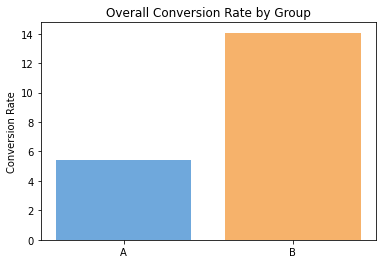

In [13]:
import matplotlib.pyplot as plt

conv = df.groupby('group')['conversion'].mean()
plt.bar(conv.index, conv.values *100, color=['#6fa8dc', '#f6b26b'])
plt.title('Overall Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.show()


## 4.2 Conversion Lift by Device

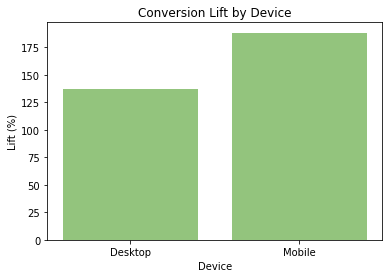

In [14]:
plt.bar(df_byDevice.index, df_byDevice['lift%'], color='#93c47d')
plt.title('Conversion Lift by Device')
plt.ylabel('Lift (%)')
plt.xlabel('Device')
plt.show()

## 4.3 Conversion Lift by Location

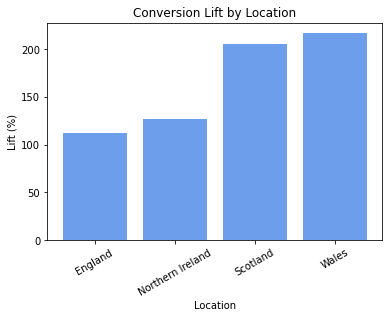

In [15]:
plt.bar(df_byLoc.index, df_byLoc['lift%'], color='#6d9eeb')
plt.title('Conversion Lift by Location')
plt.ylabel('Lift (%)')
plt.xlabel('Location')
plt.xticks(rotation=30)
plt.show()


## 4.4 time spent & page views

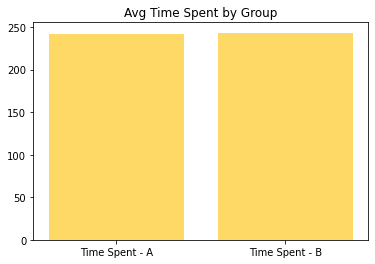

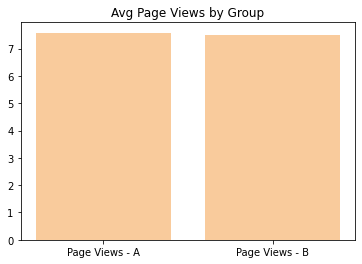

In [16]:
metrics = {
    'Time Spent': [df.query('group=="A"')['time_spent'].mean(),
                   df.query('group=="B"')['time_spent'].mean()],
    'Page Views': [df.query('group=="A"')['page_views'].mean(),
                   df.query('group=="B"')['page_views'].mean()]
}

plt.bar(['Time Spent - A','Time Spent - B'], metrics['Time Spent'], color='#ffd966')
plt.title('Avg Time Spent by Group')
plt.show()

plt.bar(['Page Views - A','Page Views - B'], metrics['Page Views'], color='#f9cb9c')
plt.title('Avg Page Views by Group')
plt.show()


## 4.5 Conversion Lift Heatmap

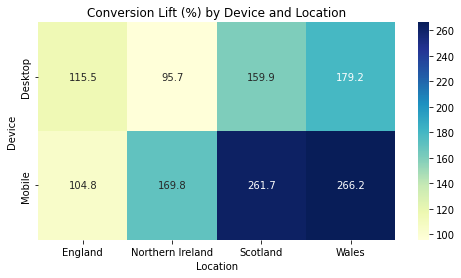

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算每个 device × location × group 的平均 conversion
df_seg = df.groupby(['device', 'location', 'group'])['conversion'].mean().reset_index()

# pivot 成 3D → 每个 device/location 对应 A、B 两列
df_pivot = df_seg.pivot_table(index=['device', 'location'], columns='group', values='conversion').reset_index()

# 计算 uplift
df_pivot['lift%'] = (df_pivot['B'] - df_pivot['A']) / df_pivot['A'] * 100

# 再 pivot 一次，让 heatmap 按 location 在 x 轴、device 在 y 轴
heatmap_data = df_pivot.pivot(index='device', columns='location', values='lift%')

# 画图
plt.figure(figsize=(8,4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Conversion Lift (%) by Device and Location")
plt.ylabel("Device")
plt.xlabel("Location")
plt.show()

